In [36]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, Bidirectional, LSTM
from keras.layers import MaxPool2D, Lambda
from keras.backend import squeeze, ctc_batch_cost
from keras.models import Model
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import string
import cv2
import os
import glob
import numpy as np
from keras.preprocessing.sequence import pad_sequences

In [2]:
char_list = string.ascii_letters+string.digits

In [3]:
inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: squeeze(x, 1))(conv_7)
 
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

#model de predict
act_model = Model(inputs, outputs)

In [4]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)       

In [5]:
path = 'C:\\Data\\Study\\IT\\Project\\Project2\\CRNN_Text_Recognition\\data\\mnt\\ramdisk\\max\\90kDICT32px'
print("Is it Directory?" + str(os.path.isdir(path)))

Is it Directory?True


In [6]:
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [16]:

training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0

i =1 
flag = 0

for root, dirnames, filenames in os.walk(path):

    for f_name in filenames:
        if f_name[-1] == 'g':

            img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   

            w, h = img.shape
            if h > 128 or w > 32:
                continue
            if w < 32:
                add_zeros = np.ones((32-w, h))*255
                img = np.concatenate((img, add_zeros))

            if h < 128:
                add_zeros = np.ones((32, 128-h))*255
                img = np.concatenate((img, add_zeros), axis=1)
            img = np.expand_dims(img , axis = 2)

            # Normalize each image
            img = img/255.
            txt = f_name.split('_')[1]

            if len(txt) > max_label_len:
                max_label_len = len(txt)

           # split data thanh 9/1
            if i%10 == 0:     
                valid_orig_txt.append(txt)   
                valid_label_length.append(len(txt))
                valid_input_length.append(31)
                valid_img.append(img)
                valid_txt.append(encode_to_labels(txt))
            else:
                orig_txt.append(txt)   
                train_label_length.append(len(txt))
                train_input_length.append(31)
                training_img.append(img)
                training_txt.append(encode_to_labels(txt)) 

            # break neu dat max data
            if i == 150000:
                flag = 1
                break
            i+=1
    if flag == 1:
        break
        
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [9]:
#test
max_label_len =18

In [10]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return ctc_batch_cost(labels, y_pred, input_length, label_length)
  
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length]) 

#model de train
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics = ['accuracy'])
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [42]:
len(char_list)

62

In [22]:
batch_size = 256
epochs = 10
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 32.5249
Epoch 00001: val_loss improved from inf to 28.26527, saving model to best_model.hdf5
36/36 [==============================] - 339s 9s/step - loss: 32.5249 - val_loss: 28.2653
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 27.9851
Epoch 00002: val_loss improved from 28.26527 to 27.60782, saving model to best_model.hdf5
36/36 [==============================] - 321s 9s/step - loss: 27.9851 - val_loss: 27.6078
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 27.5110
Epoch 00003: val_loss improved from 27.60782 to 27.57051, saving model to best_model.hdf5
36/36 [==============================] - 305s 8s/step - loss: 27.5110 - val_loss: 27.5705
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 27.2551
Epoch 00004: val_loss improved from 27.57051 to 26.86847, saving model to best_model.hdf5
36/36 [==============================] - 339s 9s/step - loss: 27.2551 -

In [11]:
act_model.load_weights('better_trained_model.hdf5')

In [12]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)       

ACCURACY

In [20]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics = ['accuracy'])

In [11]:
model.load_weights('better_trained_model.hdf5')

In [22]:
preds = model.evaluate(x = [valid_img, valid_padded_txt, valid_input_length, valid_label_length], y =np.zeros(len(valid_img)))
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

469/469 [==============================] - 135s 289ms/step - loss: 2.7462 - accuracy: 0.6823

Loss = 2.746188163757324
Test Accuracy = 0.6822666525840759


In [16]:
preds = model.evaluate(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)))
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

282/282 [==============================] - 69s 245ms/step - loss: 1.2373 - accuracy: 0.7642

Loss = 1.2372703552246094
Test Accuracy = 0.7642222046852112


In [12]:
from matplotlib.pyplot import imshow
from keras.preprocessing import image

TEST

In [13]:
import itertools
from matplotlib.pyplot import imshow

In [14]:
letters = [letter for letter in char_list]

In [15]:
def decode_label(out):
    # out : (1, 32, 128)
    out_best = list(np.argmax(out[0,:,], axis=1))  
    out_best = [k for k, g in itertools.groupby(out_best)]  
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

In [52]:
test_img_path = 'C:\\Users\\ADMIN\\Downloads\\Capture2.JPG'

In [53]:
test_img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)

In [54]:
index = 120

In [55]:
# test_img = training_img[index]

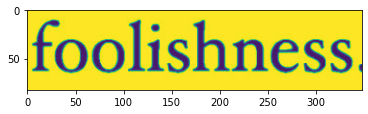

In [56]:
imshow(test_img)

In [21]:
orig_txt[index]

NameError: name 'orig_txt' is not defined

In [22]:
train_padded_txt[index]

NameError: name 'train_padded_txt' is not defined

In [57]:
im_pred = test_img
im_pred= cv2.resize(im_pred, (128, 32))
im_pred= np.expand_dims(im_pred, axis=0)
print(im_pred.shape)

(1, 32, 128)


In [58]:
result2 = act_model.predict(im_pred)
print(result2.shape)

(1, 31, 63)


In [26]:
result2.shape

(1, 31, 63)

In [27]:
np.argmax(result2, axis=2)

array([[ 5, 62, 14, 62, 62, 62, 14, 62, 11, 11, 62,  8, 62, 18, 62,  7,
        62, 62, 62, 13, 62, 62, 62,  4, 62, 62, 18, 62, 18, 18, 62]],
      dtype=int64)

In [28]:
list(np.argmax(result2[0,:,], axis=1))

[5,
 62,
 14,
 62,
 62,
 62,
 14,
 62,
 11,
 11,
 62,
 8,
 62,
 18,
 62,
 7,
 62,
 62,
 62,
 13,
 62,
 62,
 62,
 4,
 62,
 62,
 18,
 62,
 18,
 18,
 62]

In [29]:
[k for k, g in itertools.groupby(list(np.argmax(result2[0,:,], axis=1)))]

[5,
 62,
 14,
 62,
 14,
 62,
 11,
 62,
 8,
 62,
 18,
 62,
 7,
 62,
 13,
 62,
 4,
 62,
 18,
 62,
 18,
 62]

In [59]:
result2 = act_model.predict(im_pred)
pred_texts = decode_label(result2)

In [60]:
pred_texts

'foolishness'